### Как запускать это дело?

Проще всего свернуть все блоки и попорядку запустить все из них, кроме нейросетевой попытки

#### Загружаем данные в all_data

In [60]:
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [61]:
train = pd.read_csv('data/train.csv', index_col=0)
print(train.shape)
train.head()

(37518, 3)


,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
2,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5


In [62]:
test = pd.read_csv('data/test.csv', index_col=0)
print(test.shape)
test.head()

(7125, 3)


,ts,gate_id,user_word
37518,2023-01-03 08:21:00,9,gini
37519,2023-01-03 08:21:00,9,gini
37520,2023-01-03 08:21:18,5,gini
37521,2023-01-03 08:21:19,5,gini
37522,2023-01-03 08:21:39,10,gini


In [63]:
all_data = pd.concat([train, test], axis=0)
all_data['ts'] = pd.to_datetime(all_data['ts'])

# Доля тест во всей выборке
sum(all_data['user_word'].notnull()) / all_data['user_word'].shape[0] 

0.1595994892816343

### Графички

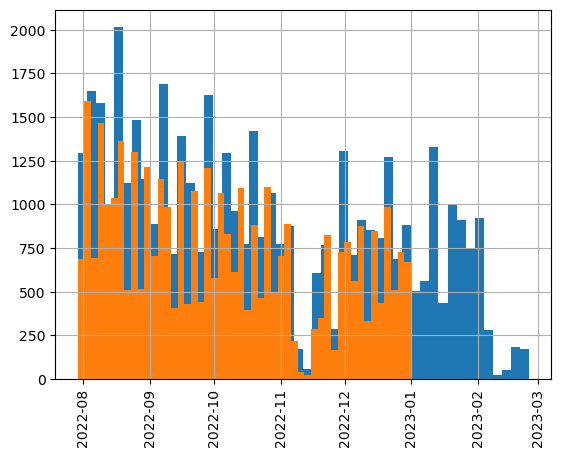

In [64]:
import seaborn as sns

plt.figure()
plt.xticks(rotation='vertical')
all_data['ts'].hist(bins=50)
train['ts'].hist(bins=50)
plt.show()


<Axes: >

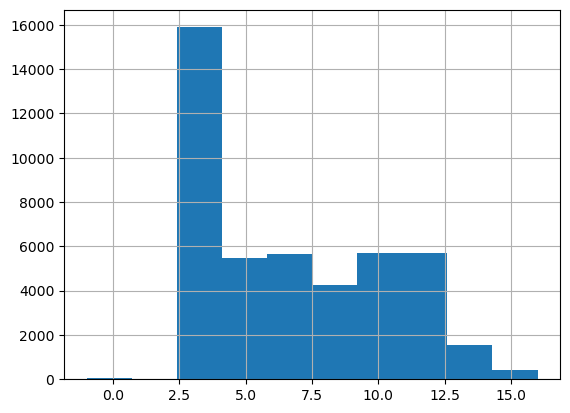

In [65]:
all_data["gate_id"].hist()

### Генерируем новые фичи

In [66]:
train_gate_list = sorted(list(train['gate_id'].unique()))
test_gate_list = sorted(list(test['gate_id'].unique()))

only_train = [gate for gate in train_gate_list if gate not in test_gate_list]
only_test = [gate for gate in test_gate_list if gate not in train_gate_list]

print("Only train gates: ", " ".join(map(str, only_train)))
print("Only test gates: ", " ".join(map(str, only_test)))

Only train gates:  0 16
Only test gates:  2


In [67]:
#1st transformation
#Adding dummies for gates

gates = pd.get_dummies(all_data['gate_id'])
gates.columns = ["gate_" + str(col) for col in gates.columns]
all_data = pd.concat([all_data, gates], axis=1)

all_data.head(1)

,user_id,ts,gate_id,user_word,gate_-1,gate_0,gate_1,gate_2,gate_3,gate_4,...,gate_7,gate_8,gate_9,gate_10,gate_11,gate_12,gate_13,gate_14,gate_15,gate_16
0,18.0,2022-07-29 09:08:54,7,NaN,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [68]:
#2nd transformation
#Adding dummies for days of week


days_of_week = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
all_data[days_of_week] = pd.get_dummies(all_data['ts'].dt.day_name())[days_of_week]

In [69]:
#3rd transformation
#Time

all_data['hour'] = all_data['ts'].dt.hour
all_data['minute'] = all_data['ts'].dt.minute
all_data['day'] = all_data['ts'].dt.day
all_data['month'] = all_data['ts'].dt.month


hours = pd.get_dummies(all_data['ts'].dt.hour)
hours.columns = ["h_" + str(col) for col in hours.columns]
all_data[hours.columns] = hours[hours.columns]

In [70]:
# 4th transformation
# Working and not working days

all_data["date"] = all_data["ts"].dt.date
count = all_data.groupby("date").size().reset_index(name='count')
result = pd.merge(all_data, count, on='date', how='left')

result["is_weekend"] = result["count"] < 100
result.drop(["count", "date"], axis=1, inplace=True)

all_data = result


In [71]:
# 5th transformation
# Gate n-grams


all_data["gate_half"] = all_data["gate_id"] <= 8

for i in range(-1, 12):
    all_data["triplet_" + str(i+1)] = (all_data["gate_id"] >= i) & (all_data["gate_id"] <= i+2)
 

In [72]:
# 6th transformation
# Estimate working, departure and arrival time


# Estimate working, departure and arrival time for train and val
stats_train = all_data[all_data.notnull()["user_id"] == True] \
    .groupby(["user_id", "month", "day"]).agg(["min", "max"])["ts"]
stats_train["diff"] = stats_train["max"] - stats_train["min"]
stats_train.rename({"diff": "diff_train", "min": "min_train", "max": "max_train"}, axis=1, inplace=True)
all_data = pd.merge(all_data, stats_train.reset_index(), how="left", on=["user_id", "month", "day"])


# Estimate working, departure and arrival time for test
stats_test = all_data[all_data.notnull()["user_id"] == False] \
    .groupby(["user_word", "month", "day"]).agg(["min", "max"])["ts"]
stats_test["diff"] = stats_test["max"] - stats_test["min"]
stats_test.rename({"diff": "diff_test", "min": "min_test", "max": "max_test"}, axis=1, inplace=True)
all_data = pd.merge(all_data, stats_test.reset_index(), how="left", on=["user_word", "month", "day"])


# Set unified column name
all_data["diff"] = all_data["diff_train"].fillna(all_data["diff_test"])
all_data["min"] = all_data["min_train"].fillna(all_data["min_test"])
all_data["max"] = all_data["max_train"].fillna(all_data["max_test"])

# Drop auxiliary columns
all_data.drop(["min_train", "max_train", "diff_train"], axis=1, inplace=True)
all_data.drop(["min_test", "max_test", "diff_test"], axis=1, inplace=True)




In [73]:
# 7th transformation
# Transform times from 6th point
all_data["diff_hour"] = all_data["diff"].dt.seconds // 3600
all_data["diff_min"] = all_data["diff"].dt.seconds % 3600 // 60

all_data["arrival_time"] = all_data["min"].dt.time
all_data["arrival_hour"] = all_data["min"].dt.hour
all_data["arrival_min"] = all_data["min"].dt.minute

all_data["departure_time"] = all_data["max"].dt.time
all_data["departure_hour"] = all_data["max"].dt.hour
all_data["departure_min"] = all_data["max"].dt.minute

all_data.drop(["diff", "min", "max"], axis=1, inplace=True)

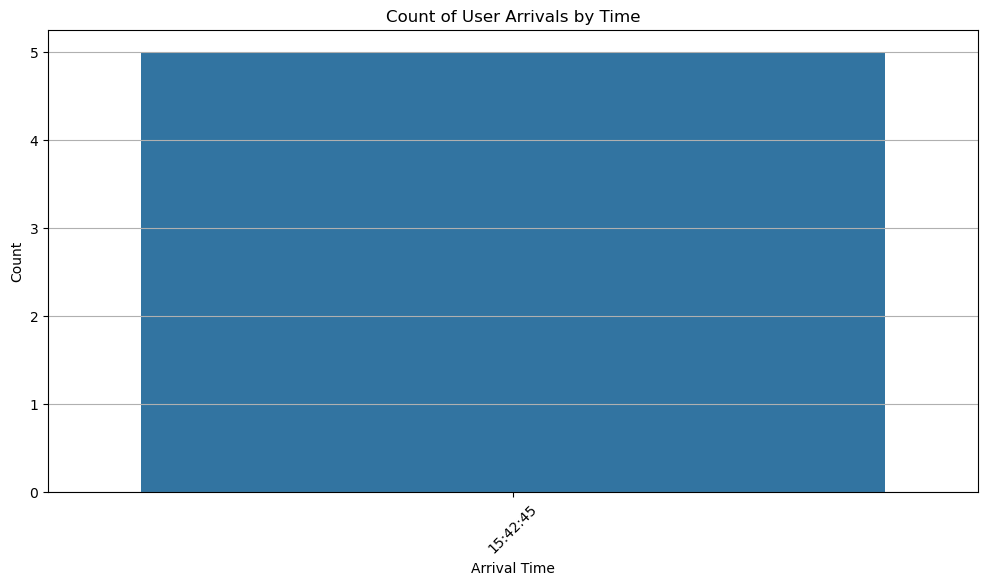

In [74]:
# logistic как будто какой-то рандомный тип, который пришел, только один раз
# Ему нужно попробовать поставить -999
# Ничего не изменилось
# В конце к нему вернемся. Но Logistic не 9 и не -999


plt.figure(figsize=(12, 6))
sns.countplot(data=all_data[all_data["user_word"] == "logistic"], x='arrival_time')

plt.xticks(rotation=45)  
plt.title('Count of User Arrivals by Time')
plt.xlabel('Arrival Time')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

In [75]:
all_data[all_data["user_word"] == "logistic"]

,user_id,ts,gate_id,user_word,gate_-1,gate_0,gate_1,gate_2,gate_3,gate_4,...,triplet_11,triplet_12,diff_hour,diff_min,arrival_time,arrival_hour,arrival_min,departure_time,departure_hour,departure_min
37670,NaN,2023-01-03 15:42:45,5,logistic,False,False,False,False,False,False,...,False,False,1,16,15:42:45,15,42,16:59:20,16,59
37672,NaN,2023-01-03 15:42:47,5,logistic,False,False,False,False,False,False,...,False,False,1,16,15:42:45,15,42,16:59:20,16,59
37681,NaN,2023-01-03 16:58:47,11,logistic,False,False,False,False,False,False,...,True,True,1,16,15:42:45,15,42,16:59:20,16,59
37682,NaN,2023-01-03 16:59:18,4,logistic,False,False,False,False,False,True,...,False,False,1,16,15:42:45,15,42,16:59:20,16,59
37683,NaN,2023-01-03 16:59:20,4,logistic,False,False,False,False,False,True,...,False,False,1,16,15:42:45,15,42,16:59:20,16,59


In [76]:
import numpy as np



# Создаем функции для вычисления среднего времени
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

def seconds_to_time(s):
    return pd.to_timedelta(s, unit='s')

test_data = all_data[all_data["user_word"].isna() == False].groupby(["user_word"]).agg(
        average_arrival_test=('arrival_time', lambda x: seconds_to_time(np.mean([time_to_seconds(t) for t in x]))),
        std_arrival_test=('arrival_time', lambda x: seconds_to_time(np.std([time_to_seconds(t) for t in x]))),
        average_departure_test=('departure_time', lambda x: seconds_to_time(np.mean([time_to_seconds(t) for t in x]))),
        std_departure_test=('departure_time', lambda x: seconds_to_time(np.std([time_to_seconds(t) for t in x])))
    )

train_data = all_data[all_data["user_word"].isna()].groupby(["user_id"]).agg(
        average_arrival_train=('arrival_time', lambda x: seconds_to_time(np.mean([time_to_seconds(t) for t in x]))),
        std_arrival_train=('arrival_time', lambda x: seconds_to_time(np.std([time_to_seconds(t) for t in x]))),
        average_departure_train=('departure_time', lambda x: seconds_to_time(np.mean([time_to_seconds(t) for t in x]))),
        std_departure_train=('departure_time', lambda x: seconds_to_time(np.std([time_to_seconds(t) for t in x])))
    )


all_data = pd.merge(all_data, test_data.reset_index(), how="left", on=["user_word"])
all_data = pd.merge(all_data, train_data.reset_index(), how="left", on=["user_id"])

all_data["average_arrival"] = (all_data["average_arrival_test"].fillna(all_data["average_arrival_train"]))
all_data["std_arrival"] = all_data["std_arrival_test"].fillna(all_data["std_arrival_train"])
all_data["average_departure"] = all_data["average_departure_test"].fillna(all_data["average_departure_train"])
all_data["std_departure"] = all_data["std_departure_test"].fillna(all_data["std_departure_train"])
all_data.drop(["average_arrival_test", "average_arrival_train", "std_arrival_test", "std_arrival_train", "average_departure_test", "average_departure_train", "std_departure_test", "std_departure_train"], axis=1, inplace=True)


all_data["average_arrival"] = all_data["average_arrival"].dt.seconds // 60
all_data["std_arrival"] = all_data["std_arrival"].dt.seconds // 60

all_data["average_departure"] = all_data["average_departure"].dt.seconds // 60
all_data["std_departure"] = all_data["std_departure"].dt.seconds // 60

all_data.drop(["arrival_time", "departure_time"], inplace=True, axis=1)

In [77]:
# 8th transformation
# Gates number


all_data['count_train'] = all_data.groupby(['user_id', 'month', 'day'])['ts'].transform('count')
all_data['count_test'] = all_data.groupby(['user_word', 'month', 'day'])['ts'].transform('count')
all_data['gates_today'] = all_data['count_train'].fillna(all_data['count_test'])
all_data.drop(['count_train', 'count_test'], axis=1, inplace=True)


forsomereason = all_data.groupby(['user_id'])['gates_today'].agg(["mean", "std"])
forsomereason.rename({"mean": "mean_train", "std": "std_train"}, axis=1, inplace=True)
all_data = pd.merge(all_data, forsomereason, on="user_id", how="left")

forsomereason = all_data.groupby(['user_word'])['gates_today'].agg(["mean", "std"])
forsomereason.rename({"mean": "mean_test", "std": "std_test"}, axis=1, inplace=True)
all_data = pd.merge(all_data, forsomereason, on="user_word", how="left")

all_data["gates_avg"] = all_data["mean_train"].fillna(all_data["mean_test"])
all_data["gates_std"] = all_data["std_train"].fillna(all_data["std_test"])
all_data.drop(['mean_train', 'mean_test', "std_test", "std_train"], axis=1, inplace=True)


In [78]:
print(all_data.columns, len(all_data.columns))

Index(['user_id', 'ts', 'gate_id', 'user_word', 'gate_-1', 'gate_0', 'gate_1',
       'gate_2', 'gate_3', 'gate_4', 'gate_5', 'gate_6', 'gate_7', 'gate_8',
       'gate_9', 'gate_10', 'gate_11', 'gate_12', 'gate_13', 'gate_14',
       'gate_15', 'gate_16', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'hour', 'minute', 'day', 'month', 'h_0',
       'h_1', 'h_3', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10', 'h_11', 'h_12',
       'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19', 'h_20', 'h_21',
       'h_22', 'h_23', 'is_weekend', 'gate_half', 'triplet_0', 'triplet_1',
       'triplet_2', 'triplet_3', 'triplet_4', 'triplet_5', 'triplet_6',
       'triplet_7', 'triplet_8', 'triplet_9', 'triplet_10', 'triplet_11',
       'triplet_12', 'diff_hour', 'diff_min', 'arrival_hour', 'arrival_min',
       'departure_hour', 'departure_min', 'average_arrival', 'std_arrival',
       'average_departure', 'std_departure', 'gates_today', 'gates_avg',
       'gates_std

In [79]:
train['ts'].agg(['max','count'])

max      2022-12-31 20:39:31
count                  37518
Name: ts, dtype: object

In [80]:
test['ts'].agg(['min','max','count'])

min      2023-01-03 08:21:00
max      2023-02-24 19:44:09
count                   7125
Name: ts, dtype: object

### Подготовить трэйн и валидацию

В результате получается два датафрейма.
- train - записи с начала до 30 ноября
- validation - записи с 30 ноября до 31 декабря

In [81]:
# Подготовим данные для train, test

train_idx = all_data['user_word'].isnull()
not_test = all_data[train_idx].copy()

In [82]:
val_index = not_test['ts'] > '2022-11-30'

train = not_test[~val_index].copy()
validation = not_test[val_index].copy()

In [83]:
train.shape, all_data.shape, validation.shape

((30535, 82), (44643, 82), (6983, 82))

### Варианты с классическим ML

In [84]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [85]:
y = train["user_id"].astype(int)
X = train.drop(["user_id", "user_word", "ts"], axis=1)

y_val = validation["user_id"].astype(int)
X_val = validation.drop(["user_id", "user_word", "ts"], axis=1)

##### Scaling (отключен)

In [86]:
to_scale = True


if to_scale:
    
    # Сделаем нормирование 
    scaler_X = StandardScaler()
    scaler_X_val = StandardScaler()
    
    X = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns)
    X_val = pd.DataFrame(scaler_X_val.fit_transform(X_val), columns=X_val.columns)

    

##### Начинаем обучени
Моделька запихивается в переменную model, чтоб потом можно было ее обучить на настоящем train

In [87]:

# Деревья уходили в переобучения. И ничего хорошего не выходило
model = KNeighborsClassifier(n_neighbors=10, metric='cosine') #104 14
model = LogisticRegression()
#model = CatBoostClassifier(learning_rate=0.001, depth=6, l2_leaf_reg=3, iterations=1000)
#model = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=21, criterion='entropy')
clf = model.fit(X, y)

y_pred = clf.predict(X)

y_val_pred = clf.predict(X_val)


### Нейросетевая попытка (Не сработала)

In [565]:
X.drop(["ts", "user_word"], axis=1, inplace=True)
X_val.drop(["ts", "user_word"], axis=1, inplace=True)

In [573]:
len(X["user_id"].unique())

50

In [567]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, dataframe, target_column):
        self.dataframe = dataframe
        self.target_column = target_column

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        features = row.drop(self.target_column).values.astype(float)  
        label = row[self.target_column]
        
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


target_column = 'user_id'
dataset = CustomDataset(X, target_column)

data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [578]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_dim, hidden_dim1)
        self.hidden2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.output = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

input_dim = 72  
hidden_dim1 = 150
hidden_dim2 = 300
output_dim = 58 

model = MLP(input_dim, hidden_dim1, hidden_dim2, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, data_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in data_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

def get_hidden_vectors(model, inputs):
    with torch.no_grad():
        hidden_layer_output = torch.relu(model.hidden1(inputs))
        return hidden_layer_output

train(model, data_loader, criterion, optimizer)

user_data = torch.randn(1, input_dim) 
user_vector = get_hidden_vectors(model, user_data)
print("User vector from hidden layer:", user_vector)


Epoch [1/10], Loss: 4.5669
Epoch [2/10], Loss: 1.9147
Epoch [3/10], Loss: 0.4321
Epoch [4/10], Loss: 2.3233
Epoch [5/10], Loss: 1.2663
Epoch [6/10], Loss: 2.9918
Epoch [7/10], Loss: 0.0277
Epoch [8/10], Loss: 0.0565
Epoch [9/10], Loss: 1.1620
Epoch [10/10], Loss: 0.0210
User vector from hidden layer: tensor([[ 0.3591,  0.0000,  1.6366,  0.5369,  0.0000,  0.0000,  0.0000,  0.0000,
         10.6264,  0.4246,  0.2583,  0.0000,  0.0000,  0.5845,  0.1144,  3.5070,
          0.0000,  0.0430,  0.0000,  0.0000,  3.4792,  3.2731,  0.3296,  0.3803,
          1.0154,  0.4255,  0.0000,  0.0257,  0.7121,  1.0507,  0.0000,  1.3996,
          0.0000,  0.0651,  0.0000,  0.0000,  5.8750,  0.0000,  0.0000,  0.0000,
          0.2281,  0.5439,  0.0000,  0.3879,  0.3671,  0.3158,  0.0000,  0.0000,
          0.0000,  6.7179,  0.7611,  0.4259,  0.1662,  0.7356,  0.0000,  0.4897,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.3409,  5.3575,  0.0000,
          0.0000,  0.2504,  0.1535,  0.0000,  0.00

In [579]:
dataset_val = CustomDataset(X_val, target_column)

In [594]:
X_val.shape

(6983, 73)

In [595]:
val_dataset = CustomDataset(X_val, target_column)

val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

model.eval()  

y_val_pred = []
with torch.no_grad():  
    for inputs, labels in val_loader:
        outputs = model(inputs)  
        _, predicted = torch.max(outputs, 1) 
        y_val_pred.extend(predicted.numpy())

In [596]:
val_loader.dataset.__len__()

6983

In [597]:
# Делаем валидацию нашей модель
y_val_word = pd.DataFrame()


y_val_word['word'] = 'user_' + y_val.astype(str) 

y_val_word['true'] = y_val

y_val_word['preds'] = y_val_pred

y_val_pred_word = pd.DataFrame(y_val_word.groupby('word')[['true','preds']].agg(lambda x: x.value_counts().index[0]))

y_val_pred_word['comp'] = y_val_pred_word['preds'] == y_val_pred_word['true']

y_val_pred_word['norm'] = 1


### Оцениваем качество

In [39]:
# Делаем валидацию нашей модель

# Создаем новые датасеты
y_word = pd.DataFrame()
y_val_word = pd.DataFrame()


# Что типа id в тестовой выборке
y_word['word'] = 'user_' + y.astype(str)
y_val_word['word'] = 'user_' + y_val.astype(str) 

# Целевая переменная ground truth
y_word['true'] = y
y_val_word['true'] = y_val

# Добавим предсказания
y_word['preds'] = y_pred
y_val_word['preds'] = y_val_pred



# Делаем датасеты с предсказаниями
y_pred_word = pd.DataFrame(y_word.groupby('word')[['true','preds']].agg(lambda x: x.value_counts().index[0]))
y_val_pred_word = pd.DataFrame(y_val_word.groupby('word')[['true','preds']].agg(lambda x: x.value_counts().index[0]))

# Добавляем сравнение с ground truth
y_pred_word['comp'] = y_pred_word['preds'] == y_pred_word['true']
y_val_pred_word['comp'] = y_val_pred_word['preds'] == y_val_pred_word['true']


# Веса юзеров мы не знаем, давайте возьмем равные веса для простоты = 1. Можно и не брать пролли
y_pred_word['norm'] = 1
y_val_pred_word['norm'] = 1


NameError: name 'y_val' is not defined

In [ ]:
# Оцениваем на train

true_answers = (y_pred_word['comp'] * y_pred_word['norm']).sum()
total_answers = y_pred_word['norm'].sum()
precent_true = round((true_answers/total_answers)*100, 1)

print('Оценка train2', true_answers, total_answers, precent_true)

Оценка train2 42 50 84.0


In [ ]:
# Оцениваем на val

true_answers_val = (y_val_pred_word['comp'] * y_val_pred_word['norm']).sum()
total_answers_val = y_val_pred_word['norm'].sum()
precent_true_val = round((true_answers_val/total_answers_val)*100, 1)

print('Оценка val', true_answers_val, total_answers_val, precent_true_val)

Оценка val 21 43 48.8


### Готовим сабмит

In [40]:
n = all_data[all_data["user_id"].notna()].shape[0]
train_df = all_data[:n]
test_df = all_data[n:]

In [41]:
y_train = train_df["user_id"].astype(int)
X_train = train_df.drop(["user_id", "user_word", "ts"], axis=1)
X_test = test_df.drop(["user_id", "user_word", "ts"], axis=1)

In [42]:
scaler_X = StandardScaler()
scaler_X_test = StandardScaler()

X_train = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler_X_test.fit_transform(X_test), columns=X_test.columns)

In [43]:
clf = model.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)

y_test_pred = clf.predict(X_test)

NameError: name 'model' is not defined

In [ ]:
test_words = pd.DataFrame()

test_words['user_word'] = test['user_word']
test_words['preds'] = y_test_pred

comp_df_test = pd.DataFrame(test_words.groupby('user_word')['preds'].agg(lambda x: x.value_counts().index[0]))

comp_df_test.to_csv('answer.csv') 


In [ ]:
! zip answer.zip answer.csv # Подготовка файла для отправки

'zip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
train_df["user_id"] == 0

0        False
1        False
2        False
3        False
4        False
         ...  
37513    False
37514    False
37515    False
37516    False
37517    False
Name: user_id, Length: 37518, dtype: bool

#### Попробуем поанализировать ручками

#### logistic

In [ ]:
# Глянем тех, у кого мало записей в трэйне. Мб подойдет
train["user_id"].value_counts()
#Слишком много вариантов. Ничего полезного

user_id
37    2262
55    2238
6     2013
12    1953
19    1793
15    1756
18    1578
47    1341
53    1311
1     1299
33    1285
11    1281
49    1275
0     1250
39    1144
32    1076
54    1070
9     1034
50     994
29     990
3      989
48     743
14     696
17     677
27     603
35     601
46     502
57     497
24     416
42     359
26     316
34     284
23     261
25     247
40     242
31     191
56     137
41     124
43     124
20     115
22      96
28      64
45      57
7       49
36      48
2       39
8       29
10      17
38      13
5       10
30      10
52       5
21       5
44       4
51       3
4        2
Name: count, dtype: int64

In [ ]:
# Пришел поздно и на час
# При этом очень много странных считываний
test_df[test_df["user_word"] == "logistic"]

,user_id,ts,gate_id,user_word,gate_-1,gate_0,gate_1,gate_2,gate_3,gate_4,...,arrival_min,departure_hour,departure_min,average_arrival,std_arrival,average_departure,std_departure,gates_today,gates_avg,gates_std
37670,NaN,2023-01-03 15:42:45,5,logistic,False,False,False,False,False,False,...,42,16,59,942,0,1019,0,5.0,5.0,0.0
37672,NaN,2023-01-03 15:42:47,5,logistic,False,False,False,False,False,False,...,42,16,59,942,0,1019,0,5.0,5.0,0.0
37681,NaN,2023-01-03 16:58:47,11,logistic,False,False,False,False,False,False,...,42,16,59,942,0,1019,0,5.0,5.0,0.0
37682,NaN,2023-01-03 16:59:18,4,logistic,False,False,False,False,False,True,...,42,16,59,942,0,1019,0,5.0,5.0,0.0
37683,NaN,2023-01-03 16:59:20,4,logistic,False,False,False,False,False,True,...,42,16,59,942,0,1019,0,5.0,5.0,0.0


In [ ]:
# Ищем нашего типа. По примерным условиям
train_df[(train_df["arrival_hour"] > 12) & (train_df["arrival_hour"] < 16) & (train_df["diff_hour"]<4) & (train_df["diff_hour"]>2)]["user_id"].value_counts()

user_id
12.0    165
14.0     60
9.0      54
15.0     33
6.0      21
56.0     20
19.0     18
34.0     14
29.0     11
46.0     11
36.0      9
40.0      7
43.0      5
Name: count, dtype: int64

In [ ]:
#Наш типок должен быть довольно редным
shortlist = [12.0, 14.0, 9.0, 15.0, 6.0, 56.0, 19.0, 34.0, 29.0, 46.0, 36.0,40.0,43.0]
train_df[train_df["user_id"].isin(shortlist)]["user_id"].value_counts()

user_id
6.0     2013
12.0    1953
19.0    1793
15.0    1756
9.0     1034
29.0     990
14.0     696
46.0     502
34.0     284
40.0     242
56.0     137
43.0     124
36.0      48
Name: count, dtype: int64

In [ ]:
# Чекаем 36 - подходит

#### y

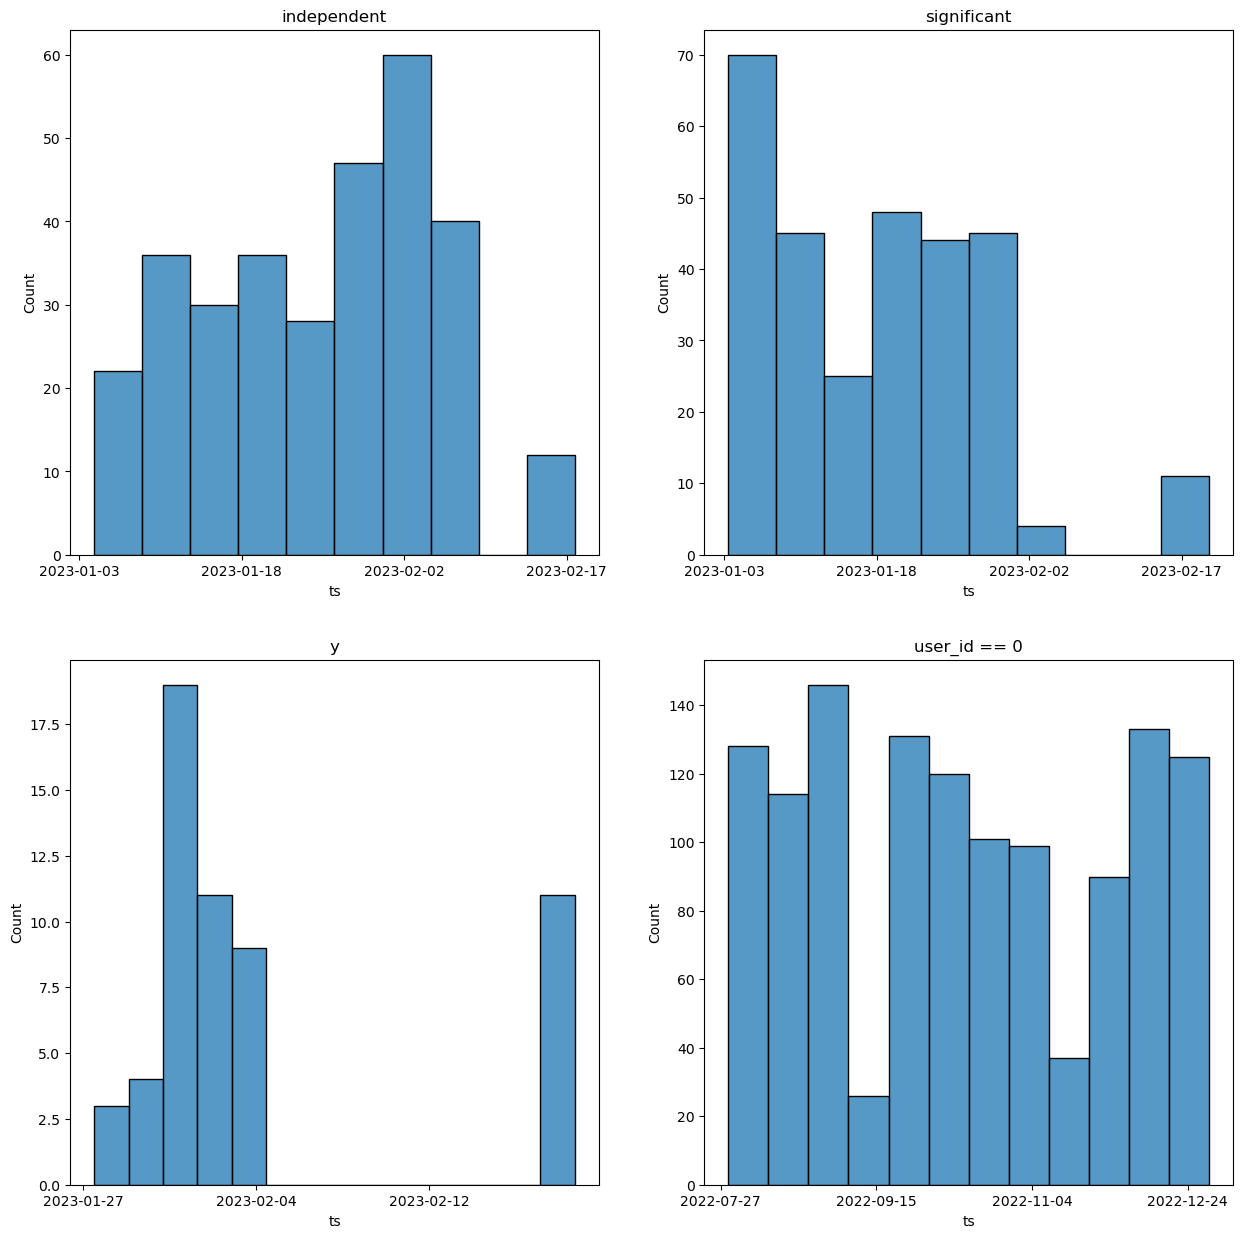

In [ ]:
# Create a plot with subplots for each value of user_word
fig, axes = plt.subplots(2, 2, figsize=(15, 15))


sns.histplot(data=test_df[test_df["user_word"] == "independent"], x="ts", ax=axes[0][0])
axes[0][0].set_title("independent")
axes[0][0].xaxis.set_major_locator(plt.MaxNLocator(4))

sns.histplot(data=test_df[test_df["user_word"] == "significant"], x="ts", ax=axes[0][1])
axes[0][1].set_title("significant")
axes[0][1].xaxis.set_major_locator(plt.MaxNLocator(4))

sns.histplot(data=test_df[test_df["user_word"] == "y"], x="ts", ax=axes[1][0])
axes[1][0].set_title("y")
axes[1][0].xaxis.set_major_locator(plt.MaxNLocator(4))

sns.histplot(data=train_df[train_df["user_id"] == 0], x="ts", ax=axes[1][1])
axes[1][1].set_title("user_id == 0")
axes[1][1].xaxis.set_major_locator(plt.MaxNLocator(4))


plt.show()


In [ ]:
# y - это какой-то подозрительный типок

only_y = test_df[test_df["user_word"] == "y"]
print(only_y.shape)

only_y.head()

(57, 82)


,user_id,ts,gate_id,user_word,gate_-1,gate_0,gate_1,gate_2,gate_3,gate_4,...,arrival_min,departure_hour,departure_min,average_arrival,std_arrival,average_departure,std_departure,gates_today,gates_avg,gates_std
42644,NaN,2023-01-27 12:37:43,6,y,False,False,False,False,False,False,...,37,12,37,778,121,1094,128,3.0,10.684211,2.619691
42645,NaN,2023-01-27 12:37:44,6,y,False,False,False,False,False,False,...,37,12,37,778,121,1094,128,3.0,10.684211,2.619691
42646,NaN,2023-01-27 12:37:50,1,y,False,False,True,False,False,False,...,37,12,37,778,121,1094,128,3.0,10.684211,2.619691
42997,NaN,2023-01-30 12:51:08,7,y,False,False,False,False,False,False,...,51,18,24,778,121,1094,128,9.0,10.684211,2.619691
42998,NaN,2023-01-30 12:51:57,3,y,False,False,False,False,True,False,...,51,18,24,778,121,1094,128,9.0,10.684211,2.619691


In [ ]:
# Первое появляение в коцне января. Вероятно, что это новенький
# Попробуем посмотреть, сколько у него и каких предсказаний


scaler_X = StandardScaler()
only_y_cutted = only_y.drop(["user_word", "user_id", "ts"], axis=1)
only_y_scaled = pd.DataFrame(scaler_X.fit_transform(only_y_cutted), columns=only_y_cutted.columns)
predicts = pd.DataFrame(clf.predict_proba(only_y_scaled))
predicts.mean() > 0.1
#47 и 6

predicts.mean()[6], predicts.mean()[47]

(0.14695409949740407, 0.31044394261471486)

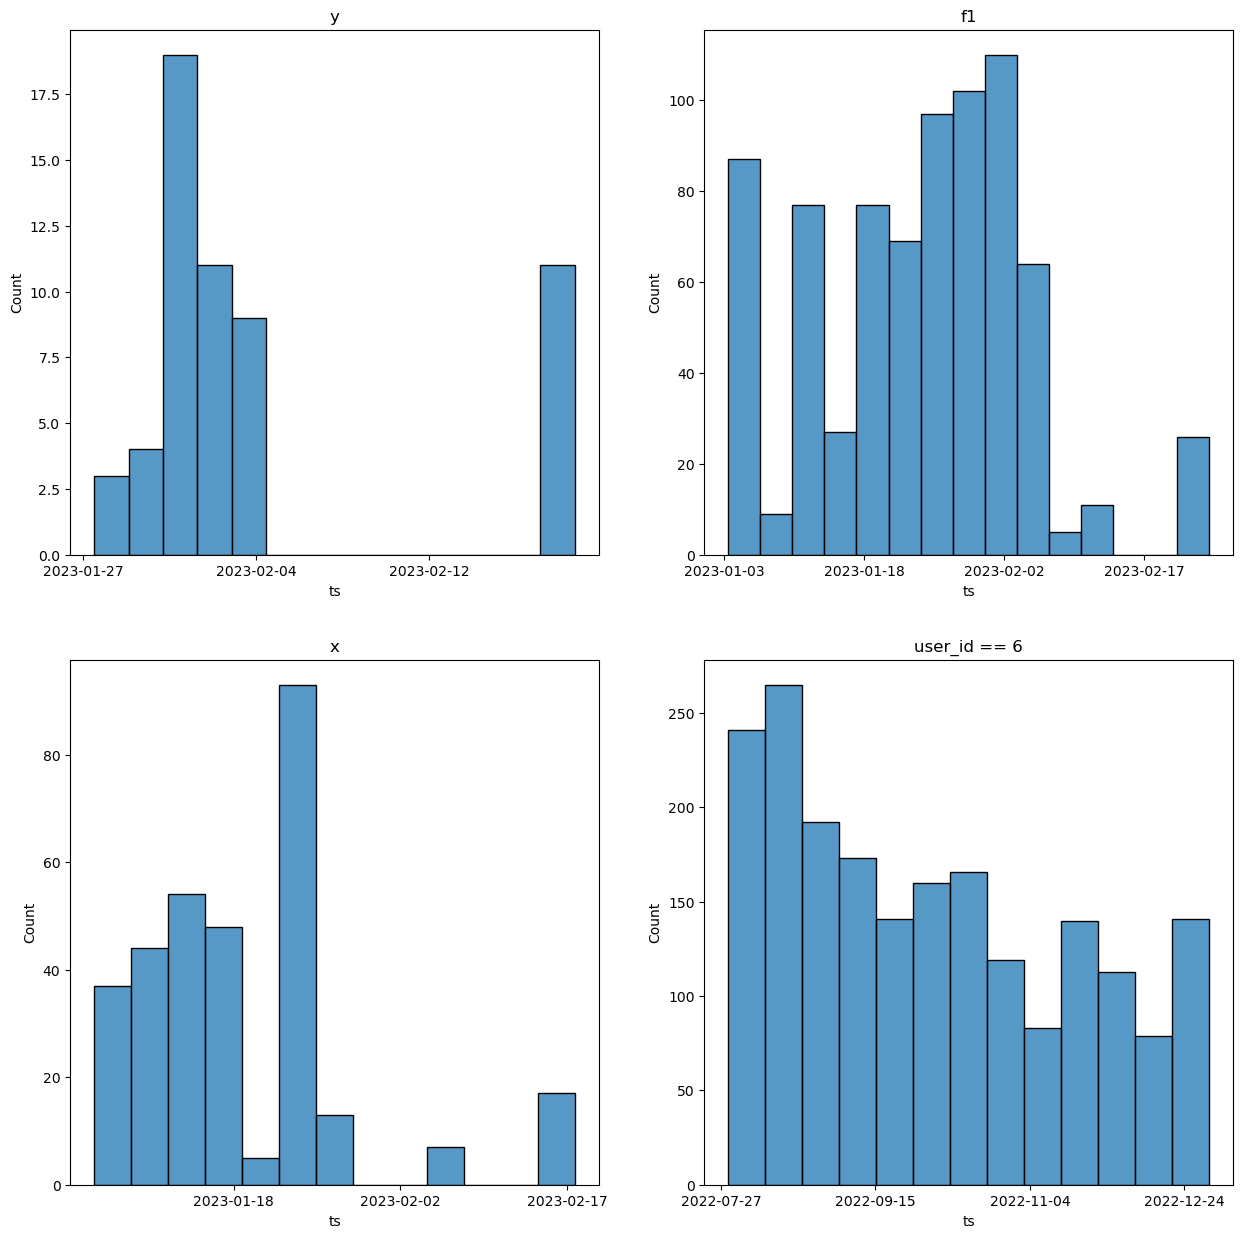

In [ ]:
# На 6 явно f1 и х больше похожи, чем y
fig, axes = plt.subplots(2, 2, figsize=(15, 15))


sns.histplot(data=test_df[test_df["user_word"] == "y"], x="ts", ax=axes[0][0])
axes[0][0].set_title("y")
axes[0][0].xaxis.set_major_locator(plt.MaxNLocator(4))

sns.histplot(data=test_df[test_df["user_word"] == "f1"], x="ts", ax=axes[0][1])
axes[0][1].set_title("f1")
axes[0][1].xaxis.set_major_locator(plt.MaxNLocator(4))

sns.histplot(data=test_df[test_df["user_word"] == "x"], x="ts", ax=axes[1][0])
axes[1][0].set_title("x")
axes[1][0].xaxis.set_major_locator(plt.MaxNLocator(4))

sns.histplot(data=train_df[train_df["user_id"] == 6], x="ts", ax=axes[1][1])
axes[1][1].set_title("user_id == 6")
axes[1][1].xaxis.set_major_locator(plt.MaxNLocator(4))


plt.show()


(1341, 82)


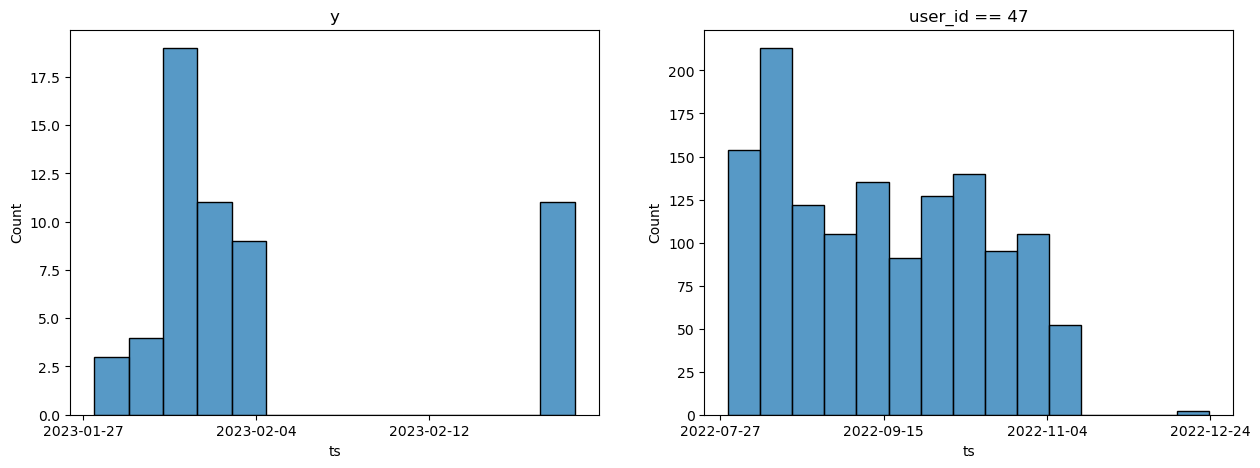

In [ ]:
# Посмотрим на 47ой
fig, axes = plt.subplots(1, 2, figsize=(15, 5))


sns.histplot(data=test_df[test_df["user_word"] == "y"], x="ts", ax=axes[0])
axes[0].set_title("y")
axes[0].xaxis.set_major_locator(plt.MaxNLocator(4))

sns.histplot(data=train_df[train_df["user_id"] == 47], x="ts", ax=axes[1])
axes[1].set_title("user_id == 47")
axes[1].xaxis.set_major_locator(plt.MaxNLocator(4))

print(train_df[train_df["user_id"] == 47].shape)
plt.show()

#Похоже, что 47ой вовсе уволился и у него не случайно нет пары.
#Тогда предположим, что y = -999

#### Фиксим значения и сохраняем их

In [ ]:
df_fix = pd.read_csv("answer.csv")

In [ ]:
df_fix.loc[14, "preds"] = 36
df_fix.loc[33, "preds"] = -999

df_fix = df_fix.groupby("user_word").mean().astype(int)
df_fix.to_csv("./answer.csv")